In [1]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import re

The file structure for the data is as follows. All downloaded folders are located in the same folder as this Jupyter notebook.

The Lahman database folder, to be downloaded [here](https://github.com/chadwickbureau/baseballdatabank/archive/master.zip), is named "baseballdatabank-master".

The Retrosheet Event Logs to be used in the "Historically" section of this notebook were downloaded [here](https://www.retrosheet.org/game.htm) by decade (see "Regular season event files by decade"). They are in folders named "1910seve", "1920seve",..., "2010seve". The Retrosheet Event Logs used in the "2019" section were downloaded as the "2019eve" folder from the same website.

The Retrosheet Game Logs were downloaded [here](https://www.retrosheet.org/gamelogs/index.html) as a single folder ("1871-2020 Game Logs"), named "gl1871_2020".

## Fetch Data

This data is from the 2020 CSV version of Lahman’s Baseball Database, to be downloaded [here](https://github.com/chadwickbureau/baseballdatabank/archive/master.zip).

In [2]:
data_dir = 'baseballdatabank-master/core/'
filepath = Path(data_dir + 'Batting.csv')

In [3]:
batting_df = pd.read_csv(filepath)

In [4]:
batting_df

,playerID,yearID,stint,teamID,lgID,G,AB,R,H,2B,...,RBI,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP
0,abercda01,1871,1,TRO,NaN,1,4,0,0,0,...,0.0,0.0,0.0,0,0.0,NaN,NaN,NaN,NaN,0.0
1,addybo01,1871,1,RC1,NaN,25,118,30,32,6,...,13.0,8.0,1.0,4,0.0,NaN,NaN,NaN,NaN,0.0
2,allisar01,1871,1,CL1,NaN,29,137,28,40,4,...,19.0,3.0,1.0,2,5.0,NaN,NaN,NaN,NaN,1.0
3,allisdo01,1871,1,WS3,NaN,27,133,28,44,10,...,27.0,1.0,1.0,0,2.0,NaN,NaN,NaN,NaN,0.0
4,ansonca01,1871,1,RC1,NaN,25,120,29,39,11,...,16.0,6.0,2.0,2,1.0,NaN,NaN,NaN,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108784,zimmebr02,2020,1,BAL,AL,2,0,0,0,0,...,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0
108785,zimmejo02,2020,1,DET,AL,3,0,0,0,0,...,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0
108786,zimmeky01,2020,1,KCA,AL,16,0,0,0,0,...,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0
108787,zuberty01,2020,1,KCA,AL,23,0,0,0,0,...,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0


What are the columns of this dataframe?

In [5]:
for col in batting_df.columns:
    print(col, end=' ')

playerID yearID stint teamID lgID G AB R H 2B 3B HR RBI SB CS BB SO IBB HBP SH SF GIDP 

How many unique players had at least one at-bat?

In [6]:
len(batting_df.loc[batting_df.AB > 0].playerID.unique())

17593

17593 over the years 1871-2019.

In [7]:
# Find the number of rows in 2019
print(len(batting_df.loc[batting_df.yearID==2019]))
# Find the number of unique players in 2019
print(len(batting_df.loc[batting_df.yearID==2019].playerID.unique()))

1569
1410


1410 unique players are listed for 2019 (not necessarily having an at-bat).

This doesn't equal the number of rows, because some players were traded during the season and therefore are given more than one row during that season.

In [8]:
batting_df.loc[(batting_df.yearID==2019) & (batting_df.playerID=='adamsau02')]

,playerID,yearID,stint,teamID,lgID,G,AB,R,H,2B,...,RBI,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP
105869,adamsau02,2019,1,WAS,NL,1,0,0,0,0,...,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0
105870,adamsau02,2019,2,SEA,AL,29,1,0,0,0,...,0.0,0.0,0.0,0,1.0,0.0,0.0,0.0,0.0,0.0


For example, `adamsau02` had two stints in 2019, one on the Nationals and one on the Mariners.

## Split up years into different dataframes

I'd like to make a dataframe for each year, where each player appears only once in each dataframe. To do this, I add the values for each player in his different stints in the season. This way I can get, say, the number of home runs hit by a given player in 2019 easily and compare this to the number he hit in a previous year. The string attributes (such as `teamID`) are automatically excluded, and I manually exclude `yearID` and `stint` since adding these (string) values doesn't make sense.

In [9]:
year_dict = {}
for year in batting_df.yearID.unique():
    year_dict[year] = batting_df.loc[(batting_df.yearID==year)].groupby(['playerID']).sum().drop(columns=['yearID', 'stint'])

In [10]:
year_dict[2019][:10]

,G,AB,R,H,2B,3B,HR,RBI,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP
playerID,,,,,,,,,,,,,,,,,
abadfe01,21,0,0,0,0,0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0
abreubr01,7,0,0,0,0,0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0
abreujo02,159,634,85,180,38,1,33,123.0,2.0,2.0,36,152.0,4.0,13.0,0.0,10.0,24.0
acunaro01,156,626,127,175,22,2,41,101.0,37.0,9.0,76,188.0,4.0,9.0,0.0,1.0,8.0
adamecr01,10,22,1,7,1,0,0,2.0,0.0,0.0,2,8.0,0.0,0.0,0.0,0.0,0.0
adamewi01,152,531,69,135,25,1,20,52.0,4.0,2.0,46,153.0,1.0,3.0,3.0,1.0,9.0
adamja01,23,0,0,0,0,0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0
adamsau01,15,0,0,0,0,0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0
adamsau02,30,1,0,0,0,0,0,0.0,0.0,0.0,0,1.0,0.0,0.0,0.0,0.0,0.0


We can see that now `adamsau02` only appears once in 2019 and played 30 games: 1 in the first stint and 29 in the second, as we can see from `batting_df`.

Out of curiosity, how many players were there in 1871 compared to today?

In [11]:
for year in [1871, 2019]:
    df = batting_df.loc[batting_df.yearID==year]
    print(len(df.teamID.unique()))
    print(len(df.playerID.unique()))
    print(len(df.loc[df.AB >= 100].playerID.unique()))
    print()

9
115
63

30
1410
437



In 1871 there were 9 teams. There were 115 players total and 63 of them had at least 100 at-bats. Compare that to 30 teams, 1410 players, and 437 players with at least 100 at-bats in 2019.

Clearly the proportion of players who bat much in a season has gone down over time, despite the larger number of games per season today. This could skew results like the average number of home runs hit by a player in the league. To avoid this, I'll cut out players with fewer than 100 at-bats in a season. How has the number of such batters changed over time?

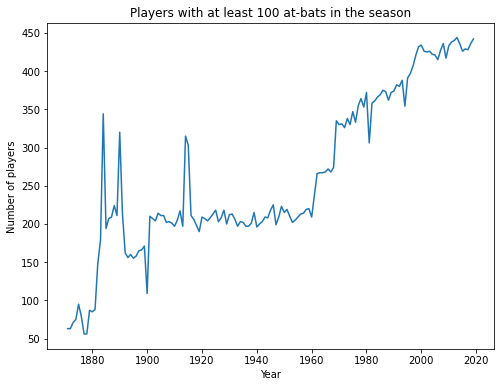

In [12]:
AB_cutoff = 100
years = range(1871, 2020)
num_players = []
for year in years:
    df = year_dict[year]
    num_players.append(len(df.loc[df.AB >= AB_cutoff]))

plt.figure(figsize=(8,6))
plt.plot(years, num_players)
plt.xlabel('Year')
plt.ylabel('Number of players')
plt.title(f'Players with at least {AB_cutoff} at-bats in the season')
plt.show()

The number of such players increased dramatically between 1960 and 1980, which I think was due to an expansion of the number of teams in the MLB.

## Home Runs per player over time

I'm curious whether players generally hit more home runs now than they did in the past. How can I make this precise?

Maybe a good measure is the fraction of players in a season who hit more than some number of home runs, say 10. I'd like to only include players who have more than some number of at-bats; I think 100 is a good cutoff here. As we can see in the above plot, today there are around 15 players per team with at least this many at-bats (there are 30 teams in the MLB). This number was lower in the past because there were fewer teams and fewer games in the season, but still the number was substantial past 1920.

To start off, I'll just make a histogram for every 10th season.

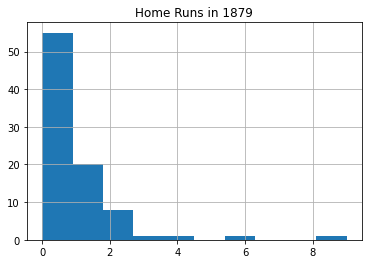

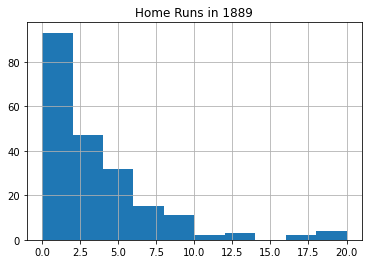

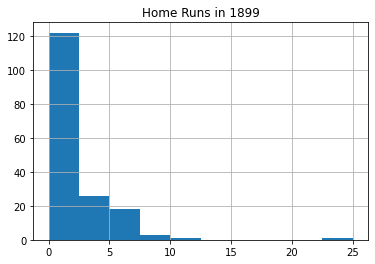

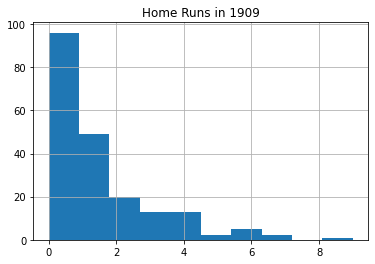

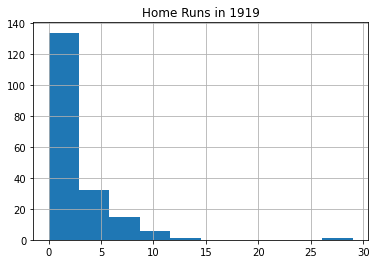

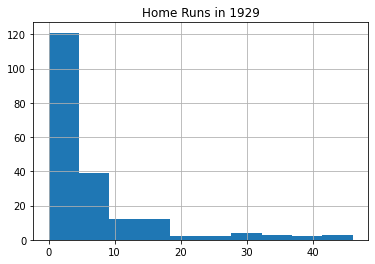

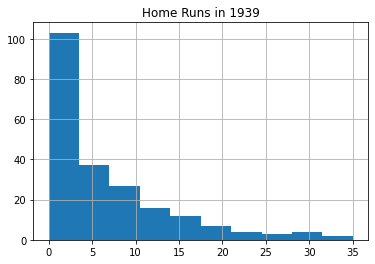

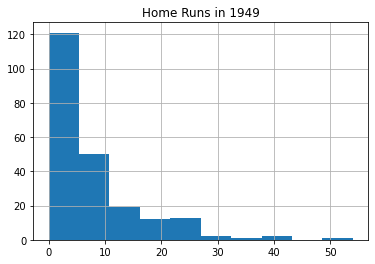

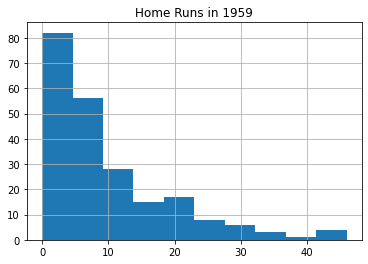

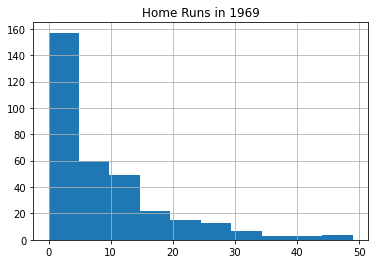

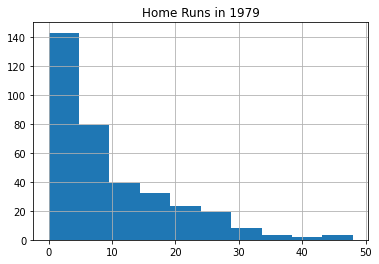

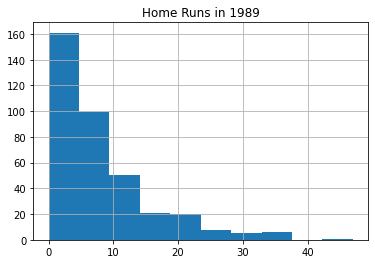

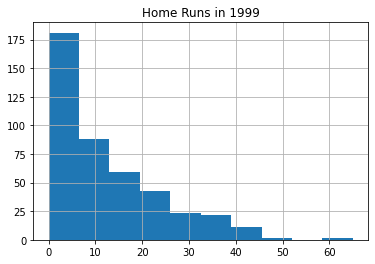

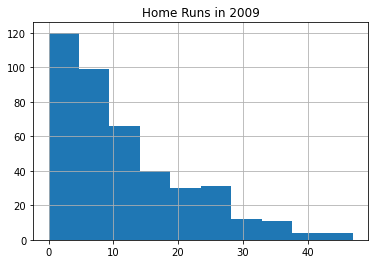

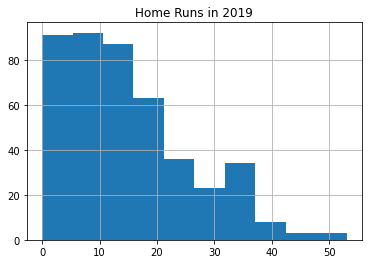

In [13]:
for year in [1879 + 10*i for i in range(15)]:
    df = year_dict[year]
    # Only consider players with more than 100 at-bats
    df.loc[df.AB > 100].hist(column='HR')
    plt.title(f'Home Runs in {year}')
    plt.show()

It does look like more players hit a good number (say, more than 10) of home runs today than in the distant past, and this fraction continues to increase. To make this more precise, I'll take a look at the fraction of players who have hit more than some cutoff number of home runs and see how this has changed over time. I'll make a plot for several cutoff values.

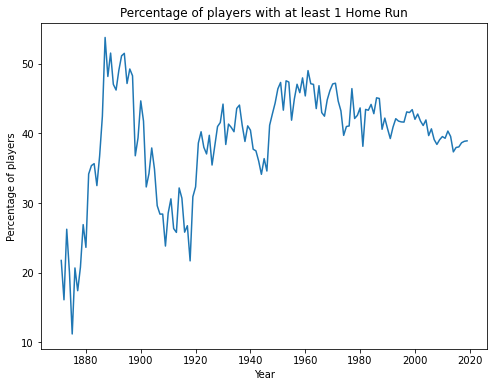

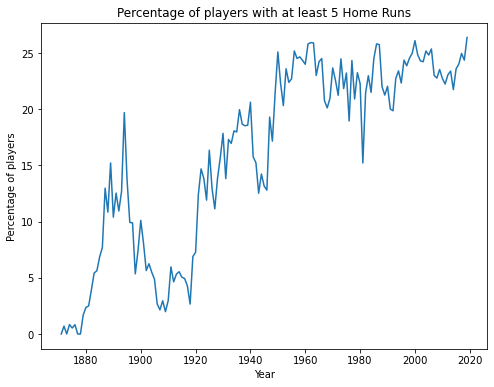

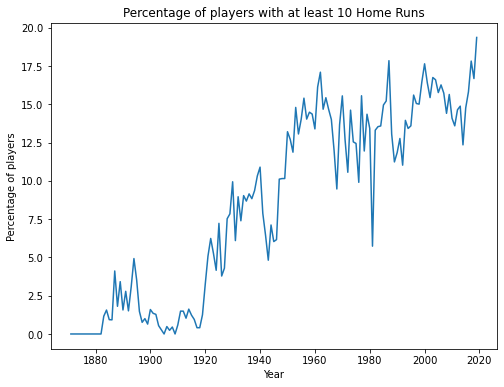

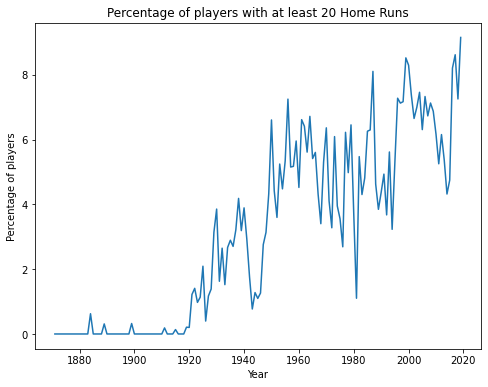

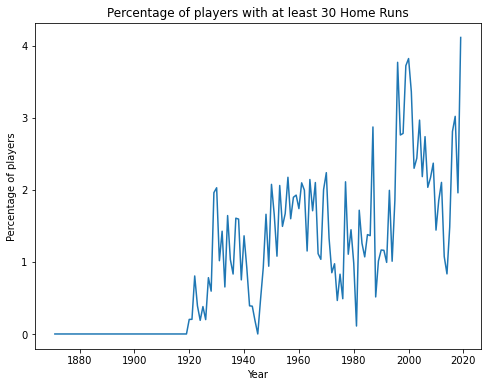

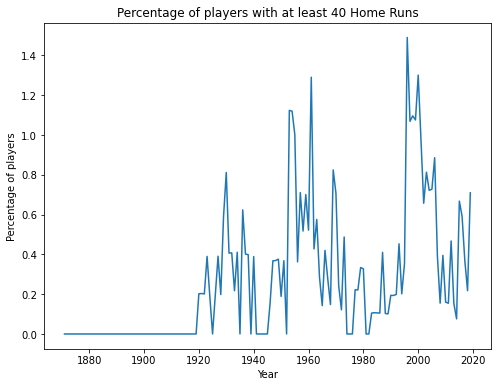

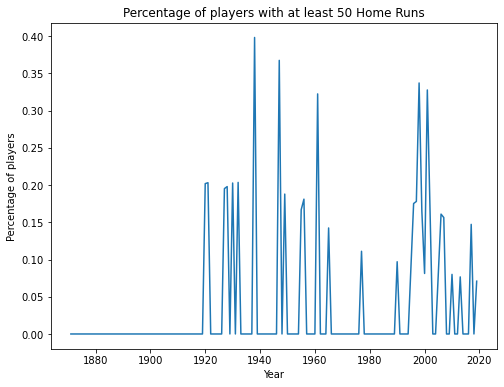

In [17]:
for cutoff in [1, 5, 10, 20, 30, 40, 50]:
    frac_players = []
    years = range(1871, 2020)
    for year in years:
        df = year_dict[year]
        num = len(df.loc[df.HR >= cutoff])
        frac_players.append(100*num/len(df))

    plt.figure(figsize=(8,6))
    plt.plot(years, frac_players)
    if cutoff == 1:
        plt.title(f'Percentage of players with at least {cutoff} Home Run')
    else:
        plt.title(f'Percentage of players with at least {cutoff} Home Runs')
    plt.xlabel('Year')
    plt.ylabel('Percentage of players')
    plt.show()

Interestingly, in the late 1800s for a few years more than half of players got a home run in a season; today that number is only about 40% and is on a level or possibly downward trend. 

Players with more than 1, 5, or 10 home runs fell drastically just before 1900 and stayed low until around 1920. This is because the type of baseball that was used changed so that it was harder to hit home runs; this is known as the era of the dead ball. Then Babe Ruth came along, and I guess the powers-that-be decided that having more home runs made the game more fun. 

There's another noteable dip during the early 1940s, particularly for the plots with cutoffs 20 and 30. I suspect this has to do with the really good young players getting drafted for WWII.

There was an interesting increase from 1990-2000 or so in the fraction of players hitting more than 20, 30, or 40 home runs; this fell and then started rising again around 2015. I suspect this has to do with rule changes involving pitching and the strike zone, and the fact that pitchers started throwing harder and likely became more dominant in the 2000-2015 era. However, the absolute numbers are here are small, so this could be a statistical fluke.

In [14]:
df = year_dict[1998]
df.loc[df.HR >= 50]

,G,AB,R,H,2B,3B,HR,RBI,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP
playerID,,,,,,,,,,,,,,,,,
griffke02,161,633,120,180,33,3,56,146.0,20.0,5.0,76,121.0,11.0,7.0,0.0,4.0,14.0
mcgwima01,155,509,130,152,21,0,70,147.0,1.0,0.0,162,155.0,28.0,6.0,0.0,4.0,8.0
sosasa01,159,643,134,198,20,0,66,158.0,18.0,9.0,73,171.0,14.0,1.0,0.0,5.0,20.0
vaughgr01,158,573,112,156,28,4,50,119.0,11.0,4.0,79,121.0,6.0,5.0,0.0,4.0,7.0


## Importance of Home Runs

Has the importance of home runs in the game changed over time? One way to tell is to look at the number of runs that are the result of a home run - that is, the number of RBIs resulting from home runs - and compare that to the total runs scored.

I can't get all this information from Lahman's baseball database. While it has the number of runs, it does not have the RBIs coming from home runs. For this I need play-by-play information, which I can get for most games using [Retrosheet](https://www.retrosheet.org).

Retrosheet uses a quite detailed format to record play-by-play information. Home runs are designated by 'HR', and right after that the runners who score as a result are indicated by '-H' (for 'to home'). For example, 'HR.1-H' means there was a runner on 1st base when the home run was hit, so that player and the player who hit the home run score, i.e. that home run is responsible for two runs. This makes it easy to determine these quantities using Python's regex engine.

I'll first figure out how many home runs were hit in 2019, how many runs were scored as a result, and how many total runs were scored that season.

### 2019 only

In [15]:
homeruns = 0
extra_runs_from_homeruns = 0
data_dir = '2019eve/'
test = []
for filepath in Path(data_dir).glob('*.EV*'):
    with open(filepath, 'r') as f:
        content = f.readlines()
        # Home runs are designated by 'HR' or 'H'
        HR_list = re.findall('.*,HR[/.\d].*', ''.join(content))
        HR_list += re.findall('.*,H[/.\d].*', ''.join(content))
        HR_list += re.findall(f'.*,HR\n', ''.join(content))
        HR_list += re.findall(f'.*,H\n', ''.join(content))
        test += re.findall('.*,HR[^/].*', ''.join(content))
        homeruns += len(HR_list)
        extra_runs_from_homeruns += sum([len(re.findall('\d-H', line)) for line in HR_list])
        # Need to include the '\d' here, meaning that a digit has to come before
        # '-H'. Otherwise we're including 'B-H' results, meaning 'batter advances to
        # home', which is already included via the home run total.
runs_from_homeruns = homeruns + extra_runs_from_homeruns
print(homeruns, "home runs were hit in 2019")
print(runs_from_homeruns, "total runs were scored as a result")

6776 home runs were hit in 2019
10617 total runs were scored as a result


I can check that the number of home runs hit matches the number recorded in Lahman's database.

In [16]:
df = year_dict[2019]
df.HR.sum()

6776

Good, they match.

There are several ways to compute the total number of runs scored.

In [18]:
# Using the Retrosheet Event Logs (play-by-play)
runs = 0
for filepath in Path(data_dir).glob('*.EV*'):
    with open(filepath, 'r') as f:
        content = f.readlines()
        runs += len(re.findall('\d-H', ''.join(content)))
        #runs += len(re.findall('.*,HR.*', ''.join(content)))
        runs += len(re.findall('.*,HR[/.\d].*', ''.join(content)))
        runs += len(re.findall('.*,H[/.\d].*', ''.join(content)))
        runs += len(re.findall(f'.*,HR\n', ''.join(content)))
        runs += len(re.findall(f'.*,H\n', ''.join(content)))
        
print(runs)

23422


In [19]:
# Using the Retrosheet Game Log
runs = 0
with open('GL2019.TXT', 'r') as f:
    games = f.readlines()
for game in games:
    record = game.split(',')
    runs += int(record[9]) + int(record[10])
print(runs)

23467


In [20]:
# Using Lahman's baseball database
df = year_dict[2019]
print(df.R.sum())

23467


In [21]:
(23467-23422)/23467

0.001917586397920484

The Game Log and Lahman numbers match and I think are likely correct. Oddly, the number I got from the Retrosheet Event Logs is lower by about 0.2%; I won't worry about this too much now since it'll be well within the uncertainty in my results. I'm not sure what caused the difference; I suspect there's some infrequent event category that also uses the '-H' designation, and I'll need to read more of the Retrosheet documentation and/or comb through some event logs more carefully for occurences of '-H' that don't mean a run was scored.

In [22]:
print(f'{runs_from_homeruns/runs:.4g}')

0.4524


So in 2019, about 45% of runs were the result of home runs. To me, that's a lot! I didn't know it was that high today.

### Historically

In [24]:
# Using Retrosheet Event Logs
# These only go back to 1915
runs_from_homeruns_dict = {}
homeruns_dict_EL = {} # EL stands for Event Logs
runs_dict_EL = {}
for decade in range(1910, 2020, 10):
    data_dir = str(decade) + 'seve/'
    start_year = 1915 if decade == 1910 else decade
    for year in range(decade, decade + 10):
        runs_from_homeruns_dict[year] = 0
        homeruns_dict_EL[year] = 0
        runs_dict_EL[year] = 0
        for filepath in Path(data_dir).glob(f'{year}*.EV*'):
            with open(filepath, 'r') as f:
                content = f.readlines()
                HR_list = re.findall(f'.*,HR[/.\d].*', ''.join(content))
                HR_list += re.findall(f'.*,H[/.\d].*', ''.join(content))
                HR_list += re.findall(f'.*,HR\n', ''.join(content))
                HR_list += re.findall(f'.*,H\n', ''.join(content))
                runs_from_homeruns_dict[year] += len(HR_list) + sum([len(re.findall('\d-H', line)) for line in HR_list])
                homeruns_dict_EL[year] += len(HR_list)
                runs_dict_EL[year] += len(HR_list) + len(re.findall('\d-H', ''.join(content)))

Check that the 2019 values match what I got above:

In [26]:
print(runs_from_homeruns_dict[2019])
print(homeruns_dict_EL[2019])
print(runs_dict_EL[2019])

10617
6776
23422


Good, they match.

In [27]:
# Using Retrosheet Game Logs
runs_dict_GL = {} # GL stands for Game Logs
data_dir = 'gl1871_2020/'
for year in range(1915, 2020):
    runs_dict_GL[year] = 0
    filepath = Path(data_dir + f'GL{str(year)}.TXT')
    with open(filepath, 'r') as f:
        games = f.readlines()
    for game in games:
        record = game.split(',')
        runs_dict_GL[year] += int(record[9]) + int(record[10])

In [28]:
year_dict[2019].HR.sum()

6776

In [29]:
# Using Lahman's Baseball Database
runs_dict_BD = {}
homeruns_dict_BD = {}
for year in range(1915, 2020):
    runs_dict_BD[year] = year_dict[year].R.sum()
    homeruns_dict_BD[year] = year_dict[year].HR.sum()

In [48]:
def plot_dict_timeseries(dicts_to_plot, title, ylab, labels=False, save_as=False):
    '''Takes dictionaries whose keys are years and plots them.
    Inputs:
            dicts_to_plot: A list of dictionaries or a single dictionary to plot.
                        The keys should be years.
            title: The title to give the plot.
            ylab: The y-axis label for the plot
            labels: A list of labels for the dictionaries that are plotted;
                    this is displayed in the legend.
                    Default is False, meaning no labels.
            save_as: The filename for the saved plot.
                    Default is False, meaning do not save.
    '''
    plt.figure(figsize=(8, 6))
    if isinstance(dicts_to_plot, dict):
        # in the case of a single dictionary, convert to a list
        dicts_to_plot = [dicts_to_plot]
    for i, dict_to_plot in enumerate(dicts_to_plot):
        list_to_plot = []
        years = sorted(dict_to_plot.keys())
        for year in years:
            list_to_plot.append(dict_to_plot[year])
        if labels:
            plt.plot(years, list_to_plot, label=labels[i])
        else:
            plt.plot(years, list_to_plot)
    plt.title(title)
    plt.xlabel('Year')
    plt.ylabel(ylab)
    if labels:
        plt.legend()
    if save_as:
        plt.savefig(save_as)
    plt.show()

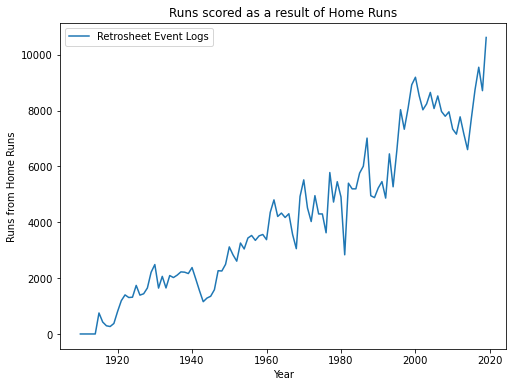

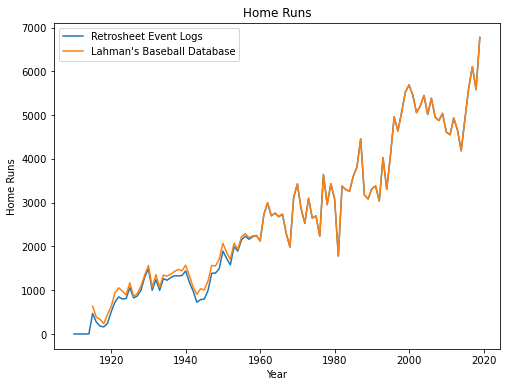

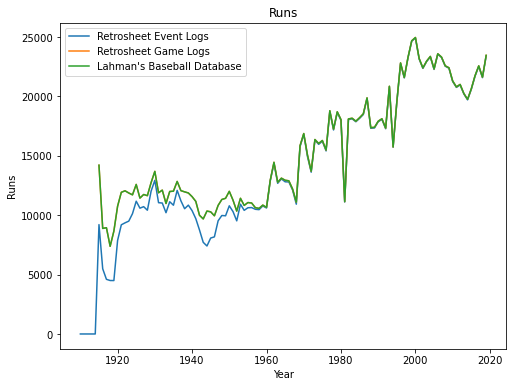

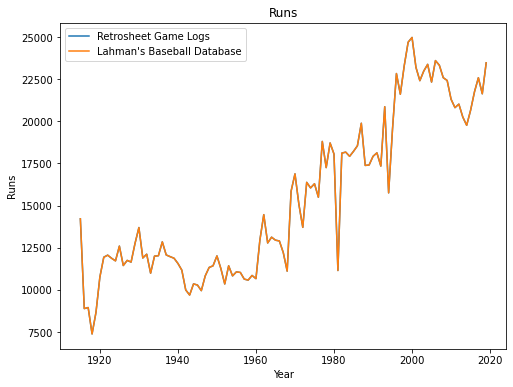

In [33]:
title = 'Runs scored as a result of Home Runs'
ylab = 'Runs from Home Runs'
labels = ['Retrosheet Event Logs']
plot_dict_timeseries(runs_from_homeruns_dict, title, ylab, labels=labels)

title = 'Home Runs'
ylab = 'Home Runs'
to_plot = [homeruns_dict_EL, homeruns_dict_BD]
labels = ['Retrosheet Event Logs', 'Lahman\'s Baseball Database']
plot_dict_timeseries(to_plot, title, ylab, labels=labels)

title = 'Runs'
ylab = 'Runs'
to_plot = [runs_dict_EL, runs_dict_GL, runs_dict_BD]
labels = ['Retrosheet Event Logs', 'Retrosheet Game Logs', 'Lahman\'s Baseball Database']
plot_dict_timeseries(to_plot, title, ylab, labels=labels)

title = 'Runs'
ylab = 'Runs'
to_plot = [runs_dict_GL, runs_dict_BD]
labels = ['Retrosheet Game Logs', 'Lahman\'s Baseball Database']
plot_dict_timeseries(to_plot, title, ylab, labels=labels)

What's going on with the home run and run totals from the Event Logs before 1960? This is concerning as it indicates that the runs scored as the result of home runs, obtained from the Event Logs, could also be significantly off before 1960.

To figure out what's going on here, I'll take a look at the year 1945 specifically, since the Event Log numbers are way off from the other numbers in that year.

What do the Event Logs say about the number of home runs hit in 1945?

In [36]:
year = 1945

homeruns = 0
extra_runs_from_homeruns = 0
data_dir = '1940seve/'
test = []
for filepath in Path(data_dir).glob(f'{year}*.EV*'):
    with open(filepath, 'r') as f:
        content = f.readlines()
        HR_list = re.findall('.*,HR[/.\d].*', ''.join(content))
        HR_list += re.findall('.*,H[/.\d].*', ''.join(content))
        HR_list += re.findall(f'.*,HR\n', ''.join(content))
        HR_list += re.findall(f'.*,H\n', ''.join(content))
        test += re.findall('.*,HR[^/].*', ''.join(content))
        homeruns += len(HR_list)
        extra_runs_from_homeruns += sum([len(re.findall('\d-H', line)) for line in HR_list])

runs_from_homeruns = homeruns + extra_runs_from_homeruns
print("According to the event logs,")
print(homeruns, f"home runs were hit in {year}")
print(runs_from_homeruns, "total runs were scored as a result")

According to the event logs,
797 home runs were hit in 1945
1351 total runs were scored as a result


In [38]:
df = year_dict[1945]
print("According to the Lahman database,")
print(f"{df.HR.sum()} home runs were hit in 1945")

According to the Lahman database,
1007 home runs were hit in 1945


Over 200 home runs were missed by the Event Logs.

To get a better handle on what's going on, I'll look at what both sources (the Event Logs and Lahman's database) say about Tommy Holmes, the 1945 home run leader.

In [39]:
year = 1945
player = 'holmt101'
all_HR = []

homeruns = 0
data_dir = '1940seve/'
test = []
for filepath in Path(data_dir).glob(f'{year}*.EV*'):
    with open(filepath, 'r') as f:
        content = f.readlines()
        HR_list = re.findall(f'{player}.*,HR[/.\d].*', ''.join(content))
        HR_list += re.findall(f'{player}.*,H[/.\d].*', ''.join(content))
        HR_list += re.findall(f'{player}.*,HR\n', ''.join(content))
        HR_list += re.findall(f'{player}.*,H\n', ''.join(content))
        homeruns += len(HR_list)
        all_HR += HR_list

runs_from_homeruns = homeruns + extra_runs_from_homeruns
print("According to the Event Logs, Tommy Holmes hit")
print(homeruns, f"home runs in {year}")

According to the Event Logs, Tommy Holmes hit
20 home runs in 1945


In [40]:
df = year_dict[1945]
df.loc[df.index == 'holmeto01']

,G,AB,R,H,2B,3B,HR,RBI,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP
playerID,,,,,,,,,,,,,,,,,
holmeto01,154,636,125,224,47,6,28,117.0,15.0,0.0,70,9.0,0.0,4.0,3.0,0.0,11.0


So according to Lahman's database, Tommy Holmes hit 28 home runs in 1945. This number is also easy to look up on the MLB's website and matches Lahman's number.

So, why are the Event Logs missing 8 of Tommy Holmes home runs in 1945? Almost certainly because the Event Logs are missing information from many games from that year; see [here](https://www.retrosheet.org/wanted/want1945.htm) for a list. I combed through '1945BSN.EVN', the Event Log for the Boston Braves' 1945 home games (Tommy Holmes played for them that year) and found that my code did not miss any of Tommy Holmes's home runs hit at home, making me reasonably confident that the Event Logs just do not contain all his home runs.

What can I do to try to still find the ratio of home runs to total runs in a meaningful way, despite some missing Event Log data? I will pull the total runs from the Event Logs, in addition to the number of runs from home runs, and calculate the ratio that way. The Event Logs are missing a lot of runs as well as home runs for certain years, but considering that the missing plays are likely random, if I pull the numbers from the same source then the ratio shouldn't be skewed.

In [41]:
test_ratio_dict = {}
for year in range(1920, 2020):
    test_ratio_dict[year] = runs_from_homeruns_dict[year]/runs_dict_EL[year]

In [42]:
ratio_dict = {}
for year in range(1920, 2020):
    ratio_dict[year] = runs_from_homeruns_dict[year]/runs_dict_BD[year]

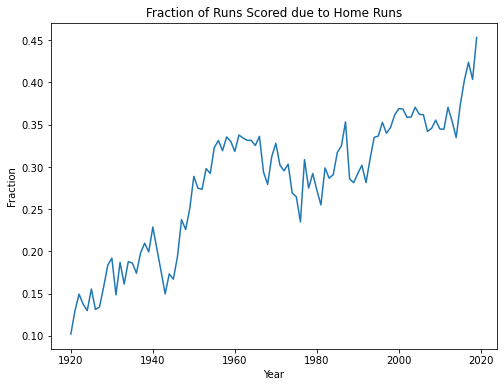

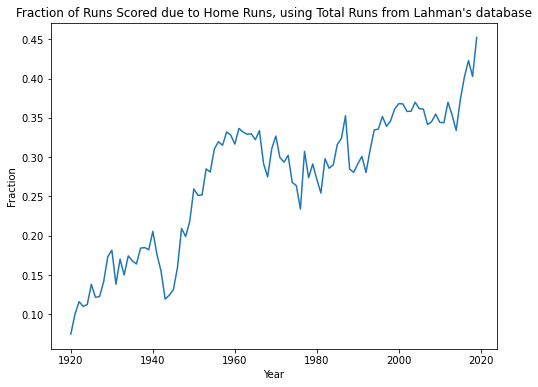

In [50]:
# From Event Logs only
title = 'Fraction of Runs Scored due to Home Runs'
ylab = 'Fraction'
save_as = 'Fraction_HR_to_Runs.png'
plot_dict_timeseries(test_ratio_dict, title, ylab, save_as=save_as)

# Denominator from Lahman's database
title = 'Fraction of Runs Scored due to Home Runs, using Total Runs from Lahman\'s database'
ylab = 'Fraction'
plot_dict_timeseries(ratio_dict, title, ylab)

Interestingly, there is a significant dip in the importance of home runs to the runs scored during the 1940s, regardless of which method I use to compute. Note though that if I compute the total runs using Lahman's database, the fraction I get is lower and certainly not correct (since the Event Logs are missing lots of home runs before 1960).

So, what's the answer to my question about how the importance of home runs has changed over time?

Home runs got more important between 1920 and 1940, drastically rising at the end of the dead ball era around 1920. The importance fell sharply during the early 1940s and rose sharply right after 1945, presumably because World War II pulled a lot of young talent out of baseball and into the draft. The importance continued to rise quickly until the late 1950s. After that it fluctuated quite a bit in roughly 5-year periods, but stayed roughly constant over longer timescales from 1960 to 2015. From about 2015 to today there's been a sharp spike in the importance of home runs; it will be interesting to see if this continues over the next few years - is it a permanent rise in importance, or just a fluctuation that will be followed by a drop to previous levels?

How many runs are scored, on average, due to a single home run? One expects this to be related to the how frequently people are getting on base. This hasn't changed that dramatically over time, so I might expect the ratio of RBIs due to home runs to number of home runs to be roughly constant.

In [51]:
test_ratio_extra_runs_to_HR_dict = {}
for year in range(1920, 2020):
    test_ratio_extra_runs_to_HR_dict[year] = runs_from_homeruns_dict[year]/homeruns_dict_EL[year]

In [52]:
ratio_extra_runs_to_HR_dict = {}
for year in range(1920, 2020):
    ratio_extra_runs_to_HR_dict[year] = runs_from_homeruns_dict[year]/homeruns_dict_BD[year]

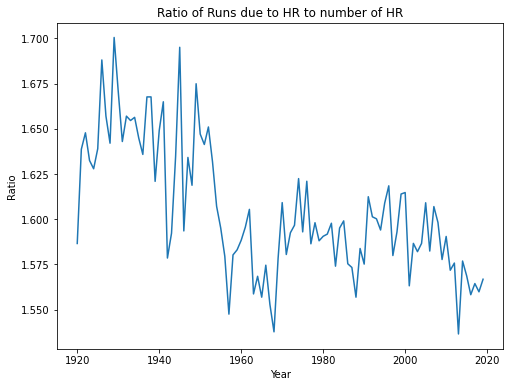

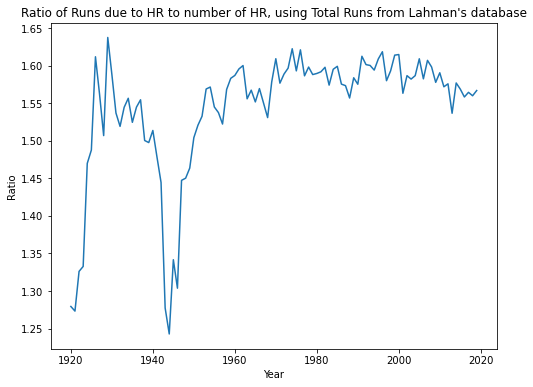

In [53]:
# From Event Logs only
title = 'Ratio of Runs due to HR to number of HR'
ylab = 'Ratio'
save_as = 'Fraction_RBIHR_to_HR.png'
plot_dict_timeseries(test_ratio_extra_runs_to_HR_dict, title, ylab, save_as=save_as)

# Denominator from Lahman's database
title = 'Ratio of Runs due to HR to number of HR, using Total Runs from Lahman\'s database'
ylab = 'Ratio'
plot_dict_timeseries(ratio_extra_runs_to_HR_dict, title, ylab)

In [54]:
years = test_ratio_extra_runs_to_HR_dict.keys()
sum([test_ratio_extra_runs_to_HR_dict[year] for year in years])/len(years)

1.6049907508688466

Observe that the plot that uses the Event Logs alone indicates that this ratio has changed little over time - perhaps it's a bit lower today than it was 1925-1950, but the fluctation is of the same magnitude. This is in sharp contrast to what happens if I take the total runs from Lahman's database; since a lot of home runs from the 1940s are missing, the ratio artificially plummets during that time - further justification for my approach of taking everything from the Event Logs for these ratio calculations.